# Mandelbrot Set Part 3 - GPU Programming

In [14]:
import numpy as np
import pyopencl as cl
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import os
from typing import Union

os.environ["PYOPENCL_COMPILER_OUTPUT"] = "0"

## OpenCL Implementation

#### Kernel Explaination
The kernel is made to take pointers to a complex mesh called C_buff, and a uint8 array called results_buff to store the results in.

Furthermore it takes arguments for max_iters and threshold as const values.

The kernel gets the id of the current work item (or pixel), that it is operating on and uses it to access the correct value in the complex mesh, as well as store the result correctly in the output array.

It initializes z as a complex datatype as $z = 0 + j0$, and creates an intermediate variable for the z_squared value.

It is important that the complex mesh and the output array is flattened, as they are indexed as a 1D vector.

The complex mesh and the output array are both kept in global memory, and passed as pointers, as these need to be accessed by all work items. While this is also the case for the threshold, and the max_iters. These variables are checked frequently for comparison in the mandelbrot set, so they are kept in constant memory for faster access.

The rest of the variables are private, as they are only used internally inside the individual work items.

#### Hardware used
| Property                     | CPU (AMD Ryzen 5 3600)       | GPU (AMD Radeon RX 5700 XT)    |
|-------------------------------|-------------------------------|------------------------------|
| Device Max Clock Speed        | 3800 MHz                         | 1905 MHz                     |
| Device Compute Units          | 12                            | 20                           |
| Device Local Memory           | 32 KB                         | 64 KB                        |
| Device Constant Memory        | 128 KB                        | 6,893,568 KB                 |
| Device Global Memory          | 16 GB                         | 8 GB                         |
| Device Max Buffer/Image Size  | 8155 MB                       | 6732 MB                      |
| Device Max Work Group Size    | 8192                          | 256                          |


In [ ]:
def mandelbrot_gpu(C:np.complex64, max_iters:np.int32, threshold:np.float32, pl_id:str, grid_size:Union[tuple[np.uint16], None] = None) -> np.ndarray[np.int32]:
    """This function computes the Mandelbrot set. It contains instructions for a openCL kernel, to compute the Mandelbrot set in parallel, using either CPU or GPU.

    Args:
        C (np.complex64): Complex mesh grid for coordinates in the Mandelbrot set.
        max_iters (np.int32): Max iterations to check while computing. Using int32 to match with default dtype in openCL kernel.
        threshold (np.float32): Threshold for divergence. Using float32 to enable comparison with absolute value complex64 values.
        pl_id (str): Platform ID. CPU or GPU.
        grid_size (tuple[np.uint16], optional): Grid size for the local work grid. Needs to be tuple with just one value. Defaults to None.

    Returns:
        np.ndarray[np.int32]: NDarray containing the number of iterations before divergence for each pixel.
    """    
    
    # opencl setup
    platforms = {"CPU": 0, "GPU": 1}
    platform = cl.get_platforms()[platforms[pl_id]]  # platform (CPU or GPU)
    device = [platform.get_devices()[0]]

    ctx = cl.Context(devices=device)
    queue = cl.CommandQueue(ctx)

    # prepare mesh grid and output
    C_flat = np.complex64(C.flatten()) # flatten to simplify C array indexing
    mset = np.zeros(C_flat.shape, dtype=np.int32)

    # create buffers for mesh and output
    mf = cl.mem_flags  # shortcut to use memory flags
    C_buff = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=C_flat)  # copy to host device
    mset_buff = cl.Buffer(ctx, mf.WRITE_ONLY, mset.nbytes)  # create buffer with size of mset in bytes

    # define kernel
    mandelbrot_kernel = """
    #include <pyopencl-complex.h>
    __kernel void compute_mandelbrot(
        __global const cfloat_t *C_buff,
        __global int *mset_buff,
        const uint max_iters,
        const float threshold
        )
    {
        private int gid = get_global_id(0);
        private cfloat_t z = cfloat_new(0.0f, 0.0f);
        private cfloat_t zsq;
        
        private cfloat_t C = cfloat_new(C_buff[gid].real, C_buff[gid].imag);
        private uint iter = 0;

        while(iter < max_iters){
            zsq = cfloat_mul(z, z);
            z = cfloat_add(zsq, C);
            float abs_z = cfloat_abs(z);
            if (abs_z >= threshold) {
                break;
            }
            iter++;
        }
        mset_buff[gid] = iter;
    }
    """
    
    # create program
    program = cl.Program(ctx, mandelbrot_kernel)
    program.build()

    # run program on chosen device
    program.compute_mandelbrot(
        queue,
        (C_flat.size,),
        grid_size,  # local work grid
        C_buff,
        mset_buff,
        np.uint32(max_iters),  # use uint32 for max_iters
        np.float32(threshold)  # use float32 for threshold
    )
    
    # copy results back from device
    cl.enqueue_copy(queue, mset, mset_buff)

    # reshape mset back into array shape
    mset = np.reshape(mset, C.shape)

    return mset


def create_mesh(re_min:int, re_max:int, im_min:int, im_max:int, p_re:int, p_im:int) -> np.ndarray[np.complex64]:
    """This function constructs a complex mesh grid from limits for the real and imaginary axis.

    Args:
        re_min (int): Minimum value for the real axis
        re_max (int): Maximum value for the real axis
        im_min (int): Minimum value for the imaginary axis
        im_max (int): Maximum value for the imaginary axis
        p_re (int): Resolution for the real axis. Number of points on the axis
        p_im (int): Resoultion for the imaginary axis. Number of points on the axis

    Returns:
        np.ndarray[np.complex64]: Complex 2D mesh grid, used for computing the Mandelbrot set
    """    

    re = np.linspace(re_min, re_max, p_re, dtype=np.complex64)
    im = np.linspace(im_min, im_max, p_im, dtype=np.complex64)
    C = re[np.newaxis, :] + 1j * im[:, np.newaxis] # create axis across columns for real part and rows for imaginary part
    
    return C.astype(np.complex64)



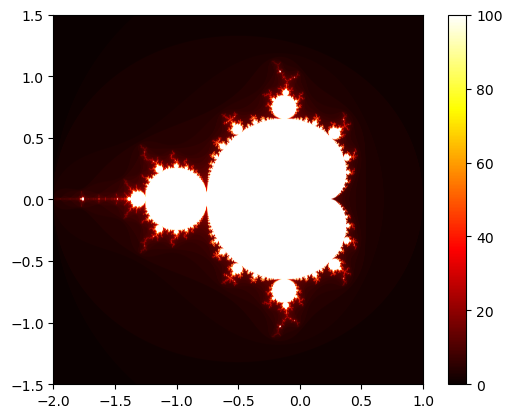

In [20]:
resolution = 10000
# grid_sizes = [8, 16, 32, 64, 128, 256]
grid_size = (128,)
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2

C = create_mesh(re_min, re_max, im_min, im_max, resolution, resolution)
mset = mandelbrot_gpu(C, max_iters, threshold, "GPU", grid_size)

plt.imshow(mset, extent=[re_min, re_max, im_min, im_max])
plt.set_cmap('hot')
plt.colorbar()
plt.show()

## Varying Local Grid Sizes


In [7]:
resolution = 20000
# grid_sizes = [8, 16, 32, 64, 128, 256]
grid_sizes = [(8,), (16,), (32,), (64,), (128,), (256,), (512,)]
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2

# dictionary to store times in
times = {
    "CPU": {size: [] for size in grid_sizes},
    "GPU": {size: [] for size in grid_sizes}
}

platform_names = ["CPU", "GPU"]

for pl in platform_names:
    for size in grid_sizes:
        try:
            print(f"{pl}: grid size {size}")
            start = timer()
            C = create_mesh(re_min, re_max, im_min, im_max, resolution, resolution)
            mset = mandelbrot_gpu(C, max_iters, threshold, pl, size)
            times[pl][size] = timer() - start
        except cl.LogicError:
            print(f"Invalid work group size: {size}. Skipping...")
            times[pl][size] = -1
            continue
    print("#####################################")

CPU: grid size (8,)


c:\Users\clyho\miniconda3\envs\opencl-env\Lib\site-packages\pyopencl\cache.py:496: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
c:\Users\clyho\miniconda3\envs\opencl-env\Lib\site-packages\pyopencl\cache.py:500: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, devices)


CPU: grid size (16,)
CPU: grid size (32,)
CPU: grid size (64,)
CPU: grid size (128,)
CPU: grid size (256,)
CPU: grid size (512,)
#####################################
GPU: grid size (8,)
GPU: grid size (16,)
GPU: grid size (32,)
GPU: grid size (64,)
GPU: grid size (128,)
GPU: grid size (256,)
GPU: grid size (512,)
Invalid work group size: (512,). Skipping...
#####################################


### Performance Comparison of Work Grid Sizes
This comparison is done with a rather large resolution for the mandelbrot set. This was done to get runtimes that are not super small, and to allow the larger work grid sizes to work more.

The results show that the GPU is significantly faster than the CPU for all work grid sizes. However it also shows that the GPU caps out at a work grid size of 256, while the CPU can continue going higher.

The decrease in speed for the largest work grid size for the CPU is probably due to memory overflow during the computation. This is suspected as the entire pc froze during the computation :(.

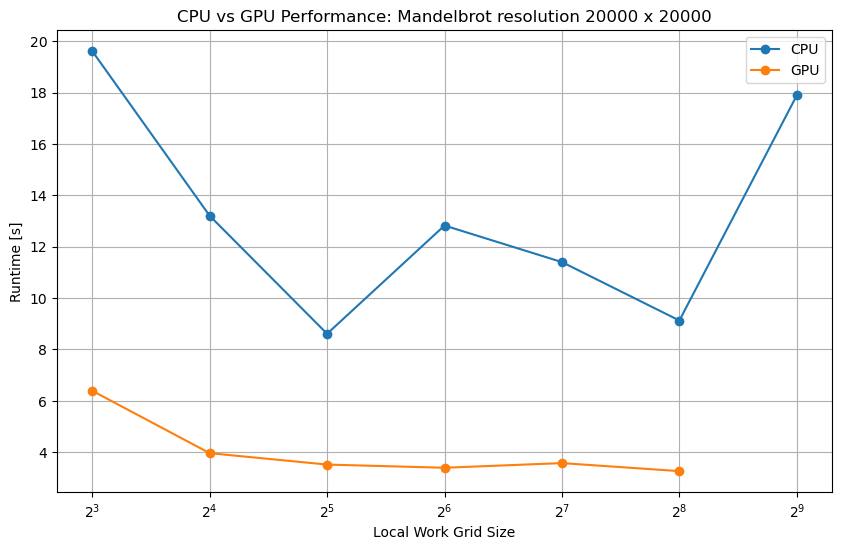

In [12]:
# exclude fields with invalid work group size
valid_cpu_data = {size: runtime for size, runtime in times["CPU"].items() if runtime != -1}
valid_gpu_data = {size: runtime for size, runtime in times["GPU"].items() if runtime != -1}

# convert from tuples to lists
# e.g. [(16,), (32,)] -> [16,32]
grid_sizes_cpu = [size[0] for size in valid_cpu_data.keys()]
runtime_cpu = list(valid_cpu_data.values())

grid_sizes_gpu = [size[0] for size in valid_gpu_data.keys()]
runtime_gpu = list(valid_gpu_data.values())

plt.figure(figsize=(10, 6))
plt.plot(grid_sizes_cpu, runtime_cpu, "o-", label="CPU")
plt.plot(grid_sizes_gpu, runtime_gpu, 'o-', label="GPU")

plt.xlabel("Local Work Grid Size")
plt.ylabel("Runtime [s]")
plt.title(f"CPU vs GPU Performance: Mandelbrot resolution {resolution} x {resolution}")
plt.grid(True)
plt.legend()
plt.xscale("log", base=2)  # Log scale for better visualization

## Varying Mandelbrot Resoultion

In [ ]:
resolutions = [1000, 2000, 3000, 5000, 10000, 15000]
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2

# dictionary to store times in
times = {
    "CPU": {res: [] for res in resolutions},
    "GPU": {res: [] for res in resolutions}
}

platform_names = ["CPU", "GPU"]

for pl in platform_names:
    for res in resolutions:
        print(f"{pl}: resolution {res}")
        start = timer()
        C = create_mesh(re_min, re_max, im_min, im_max, res, res)
        mset = mandelbrot_gpu(C, max_iters, threshold, pl)
        times[pl][res] = timer() - start

CPU: resolution 1000
CPU: resolution 2000
CPU: resolution 3000
CPU: resolution 5000
CPU: resolution 10000
CPU: resolution 15000
GPU: resolution 1000
GPU: resolution 2000
GPU: resolution 3000
GPU: resolution 5000
GPU: resolution 10000
GPU: resolution 15000


### Platform Comparison of Resoultions
It is apparent that the GPU is outperforming the CPU for most of the resolutions tested. However it is worth noting that for small grids, the CPU is actually on par, and actually beats the GPU for the smallest size.

This is somewhat expected, as the strength of using the GPU comes from being able to do a large number of operations in parallel. This strength is not useful when the grid is too small, and the overhead of transfering data between devices, may be more costly than benefitial.

It should also be noted that these runtimes are achieved after already building the kernel once. This matters as pyopencl caches the kernel, making it significantly faster for subsequent runs.

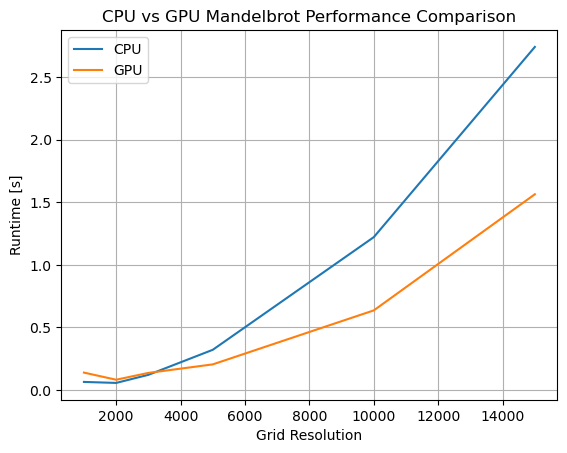

In [ ]:
plt.Figure(figsize=(10,6))

plt.plot(resolutions, [times["CPU"][res] for res in resolutions], label = "CPU")
plt.plot(resolutions, [times["GPU"][res] for res in resolutions], label = "GPU")

plt.xlabel('Grid Resolution')
plt.ylabel('Runtime [s]')

plt.title('CPU vs GPU Mandelbrot Performance Comparison')
plt.legend()
plt.grid(True)

## Unit Tests
3 unit tests are created using the unittest framework and can be found in the test_mandelbrot_opencl.py script, and the mandelbrot_opencl.py is just this notebook in script form.

All unit tests work with a smaller grid than what is used in this notebook.

**The first test**, tests that the shape of the output is as expected, and that the set contains pixels which have diverged (iterations < max_iters), and that there are some which didn't diverge.

**The second test** creates a 2x2 grid, where pixels in the first column will should not diverge and pixels in the second column should diverge.

**The third test** verifies that chosing a parameter for the grid_size, doesn't affect the mandelbrot results, only the runtime.

All tests passed.